In [62]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 3 # Options are [1, 2, 3, 4]
test_type = 'attack_type' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.Attack_Tag,response.headers.Location,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie
0,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,GET,http://127.0.0.1:5000/bookstore/signup?usernam...,,400 BAD REQUEST,application/json,76,400,"{""message"": ""This username is already taken, p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/forum?message=%3C%2Fp%3E...,,302 FOUND,text/html; charset=utf-8,199,302,text/html; charset=utf-8,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=N6BKSYvbHZ-c7Nvn6ITB2Q7yJddttJSdw-LNw7PIJ...,"Thu, 15 Dec 2022 00:25:51 GMT",XSS,/forum,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/about/greet?resource_id=...,,200 OK,text/html; charset=utf-8,546,200,text/html; charset=utf-8,de-CH,none,websocket,?1,document,['ck=W8ONnD95GriBOMxq2rHpMUXFIHT5bKv0QPZiOea0E...,"Thu, 15 Dec 2022 00:20:24 GMT",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/orders/get/ship_via/3,,200 OK,application/json,343,200,"{""customer_id"": ""VINET"", ""employee_id"": ""5"", ""...","en-US,en;q=0.5",none,same-origin,?1,document,['ck=ms3dG65An9Vqx-2x--24w_j8ro90Bpp9gqZJVM03I...,"Thu, 15 Dec 2022 00:33:30 GMT",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/about/greet?resource_id=...,,200 OK,text/html; charset=utf-8,376,200,text/html; charset=utf-8,de,none,same-origin,?1,document,['ck=7mBcmslAl5Fpg5jiXWtM8qSZUhGIwFLP1sBYSUMvk...,"Thu, 15 Dec 2022 00:42:19 GMT",NaN,NaN,NaN,NaN,NaN


# Basic dataset label arrangements

In [63]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,response.headers.Location,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,GET,http://127.0.0.1:5000/bookstore/signup?usernam...,,400 BAD REQUEST,application/json,76,400,"{""message"": ""This username is already taken, p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/forum?message=%3C%2Fp%3E...,,302 FOUND,text/html; charset=utf-8,199,302,text/html; charset=utf-8,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=N6BKSYvbHZ-c7Nvn6ITB2Q7yJddttJSdw-LNw7PIJ...,"Thu, 15 Dec 2022 00:25:51 GMT",/forum,NaN,NaN,NaN,XSS,Malware
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/about/greet?resource_id=...,,200 OK,text/html; charset=utf-8,546,200,text/html; charset=utf-8,de-CH,none,websocket,?1,document,['ck=W8ONnD95GriBOMxq2rHpMUXFIHT5bKv0QPZiOea0E...,"Thu, 15 Dec 2022 00:20:24 GMT",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/orders/get/ship_via/3,,200 OK,application/json,343,200,"{""customer_id"": ""VINET"", ""employee_id"": ""5"", ""...","en-US,en;q=0.5",none,same-origin,?1,document,['ck=ms3dG65An9Vqx-2x--24w_j8ro90Bpp9gqZJVM03I...,"Thu, 15 Dec 2022 00:33:30 GMT",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/about/greet?resource_id=...,,200 OK,text/html; charset=utf-8,376,200,text/html; charset=utf-8,de,none,same-origin,?1,document,['ck=7mBcmslAl5Fpg5jiXWtM8qSZUhGIwFLP1sBYSUMvk...,"Thu, 15 Dec 2022 00:42:19 GMT",NaN,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,GET,http://127.0.0.1:5000/bookstore/signup?usernam...,,400 BAD REQUEST,application/json,76,400,"{""message"": ""This username is already taken, p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign,Benign
144496,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/states/Amy?id=8408766.17...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}","en-US,en;q=0.5",none,websocket,?1,document,['ck=K4ze3MQyPwZr2g11VWiL5jcP0qX0YiAjD8dqbdZ5E...,"Thu, 15 Dec 2022 00:49:52 GMT",NaN,NaN,NaN,NaN,Benign,Benign
144497,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/orders/get/country?count...,,404 NOT FOUND,application/json,46,404,"{""error"": ""No records found for this country""}",de-CH,none,same-origin,?1,document,['ck=jqYAfZFYqgBNw_4OUCwMxCZI6-YknUzwkz5bFsl-I...,"Thu, 15 Dec 2022 00:34:55 GMT",NaN,NaN,NaN,NaN,Benign,Benign
144498,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/orders/check/exists?val=...,,401 UNAUTHORIZED,application/json,41,401,"{""error"": ""Not a number failed to parse""}",de,none,websocket,?1,document,['ck=gWjT0HHHjI_M7uyswSILxgBtoW2OZ7ztEzHgZxGDg...,"Thu, 15 Dec 2022 00:33:41 GMT",NaN,NaN,NaN,NaN,Benign,Benign


In [64]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,response.headers.Location,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,GET,http://127.0.0.1:5000/bookstore/signup?usernam...,,400 BAD REQUEST,application/json,76,400,"{""message"": ""This username is already taken, p...",None,None,None,None,None,None,None,None,None,None,None,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/forum?message=%3C%2Fp%3E...,,302 FOUND,text/html; charset=utf-8,199,302,text/html; charset=utf-8,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=N6BKSYvbHZ-c7Nvn6ITB2Q7yJddttJSdw-LNw7PIJ...,"Thu, 15 Dec 2022 00:25:51 GMT",/forum,None,None,None,XSS,Malware
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/about/greet?resource_id=...,,200 OK,text/html; charset=utf-8,546,200,text/html; charset=utf-8,de-CH,none,websocket,?1,document,['ck=W8ONnD95GriBOMxq2rHpMUXFIHT5bKv0QPZiOea0E...,"Thu, 15 Dec 2022 00:20:24 GMT",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/orders/get/ship_via/3,,200 OK,application/json,343,200,"{""customer_id"": ""VINET"", ""employee_id"": ""5"", ""...","en-US,en;q=0.5",none,same-origin,?1,document,['ck=ms3dG65An9Vqx-2x--24w_j8ro90Bpp9gqZJVM03I...,"Thu, 15 Dec 2022 00:33:30 GMT",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,GET,http://127.0.0.1:5000/about/greet?resource_id=...,,200 OK,text/html; charset=utf-8,376,200,text/html; charset=utf-8,de,none,same-origin,?1,document,['ck=7mBcmslAl5Fpg5jiXWtM8qSZUhGIwFLP1sBYSUMvk...,"Thu, 15 Dec 2022 00:42:19 GMT",None,None,None,None,Benign,Benign


In [65]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=3)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,response.headers.Location,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,0,0.000000,0,0,0,0,0.447214,3,0.000000,400,0.801784,0,0,0,1,0,0.000000,0.0,0.0,0.0,0.0,Benign,Benign
1,0,0.000000,1,0,0,0,0.688247,1,-0.408248,302,-0.408248,4,1,1,0,1,-0.190693,0.0,0.0,0.0,0.0,XSS,Malware
2,0,-0.707107,1,0,0,0,-0.316228,0,-0.408248,200,-0.408248,2,1,2,0,1,-0.145479,0.0,0.0,0.0,0.0,Benign,Benign
3,0,0.000000,1,0,0,0,0.408248,0,0.000000,200,0.975900,3,1,1,0,1,0.374766,0.0,0.0,0.0,0.0,Benign,Benign
4,0,0.000000,1,0,0,0,0.447214,0,-0.408248,200,-0.408248,1,1,1,0,1,0.090167,0.0,0.0,0.0,0.0,Benign,Benign


In [66]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Host             144500 non-null  int32  
 1   request.headers.User-Agent       144500 non-null  float64
 2   request.headers.Accept-Encoding  144500 non-null  int32  
 3   request.headers.Accept           144500 non-null  int32  
 4   request.headers.Connection       144500 non-null  int32  
 5   request.method                   144500 non-null  int32  
 6   request.url                      144500 non-null  float64
 7   response.status                  144500 non-null  int32  
 8   response.headers.Content-Type    144500 non-null  float64
 9   response.status_code             144500 non-null  int64  
 10  response.body                    144500 non-null  float64
 11  request.headers.Accept-Language  144500 non-null  int32  
 12  re

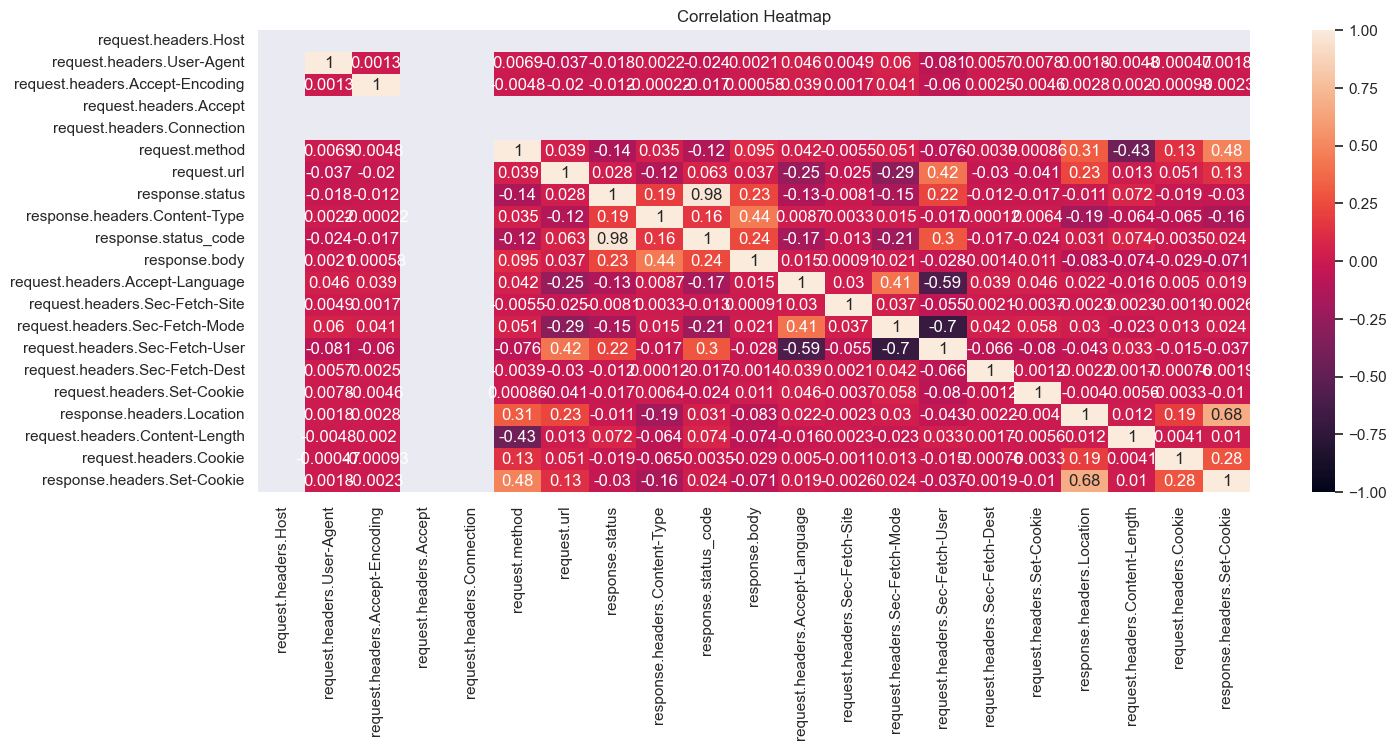

In [67]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

In [68]:
# df.drop('request.method', axis=1, inplace=True)
df.drop('response.status_code', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,response.headers.Location,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,0,0.000000,0,0,0,0,0.447214,3,0.000000,0.801784,0,0,0,1,0,0.000000,0.0,0.0,0.0,0.0,Benign,Benign
1,0,0.000000,1,0,0,0,0.688247,1,-0.408248,-0.408248,4,1,1,0,1,-0.190693,0.0,0.0,0.0,0.0,XSS,Malware
2,0,-0.707107,1,0,0,0,-0.316228,0,-0.408248,-0.408248,2,1,2,0,1,-0.145479,0.0,0.0,0.0,0.0,Benign,Benign
3,0,0.000000,1,0,0,0,0.408248,0,0.000000,0.975900,3,1,1,0,1,0.374766,0.0,0.0,0.0,0.0,Benign,Benign
4,0,0.000000,1,0,0,0,0.447214,0,-0.408248,-0.408248,1,1,1,0,1,0.090167,0.0,0.0,0.0,0.0,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,0,0.000000,0,0,0,0,0.577350,3,0.000000,0.801784,0,0,0,1,0,0.000000,0.0,0.0,0.0,0.0,Benign,Benign
144496,0,-0.137361,1,0,0,0,-0.408248,5,0.000000,0.707107,3,1,2,0,1,-0.390360,0.0,0.0,0.0,0.0,Benign,Benign
144497,0,-0.577350,1,0,0,0,0.267261,5,0.000000,0.000000,2,1,1,0,1,-0.624695,0.0,0.0,0.0,0.0,Benign,Benign
144498,0,-0.137361,1,0,0,0,0.707107,4,0.000000,0.408248,1,1,2,0,1,-0.190693,0.0,0.0,0.0,0.0,Benign,Benign


# Check which fields don't matter

maybe fill this

# Drop unnecessary fields

In [69]:
df.drop('request.headers.Host', axis=1, inplace=True)
df.drop('request.headers.Accept', axis=1, inplace=True)
df.drop('request.headers.Connection', axis=1, inplace=True)
# df.drop('response.headers.Content-Type', axis=1, inplace=True)

In [70]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.body', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'response.headers.Location', 'request.headers.Content-Length', 'request.headers.Cookie', 'response.headers.Set-Cookie']


request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.body                      float64
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
response.headers.Location          float64
request.headers.Content-Length     float64
request.headers.Cookie             float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
dtype: object

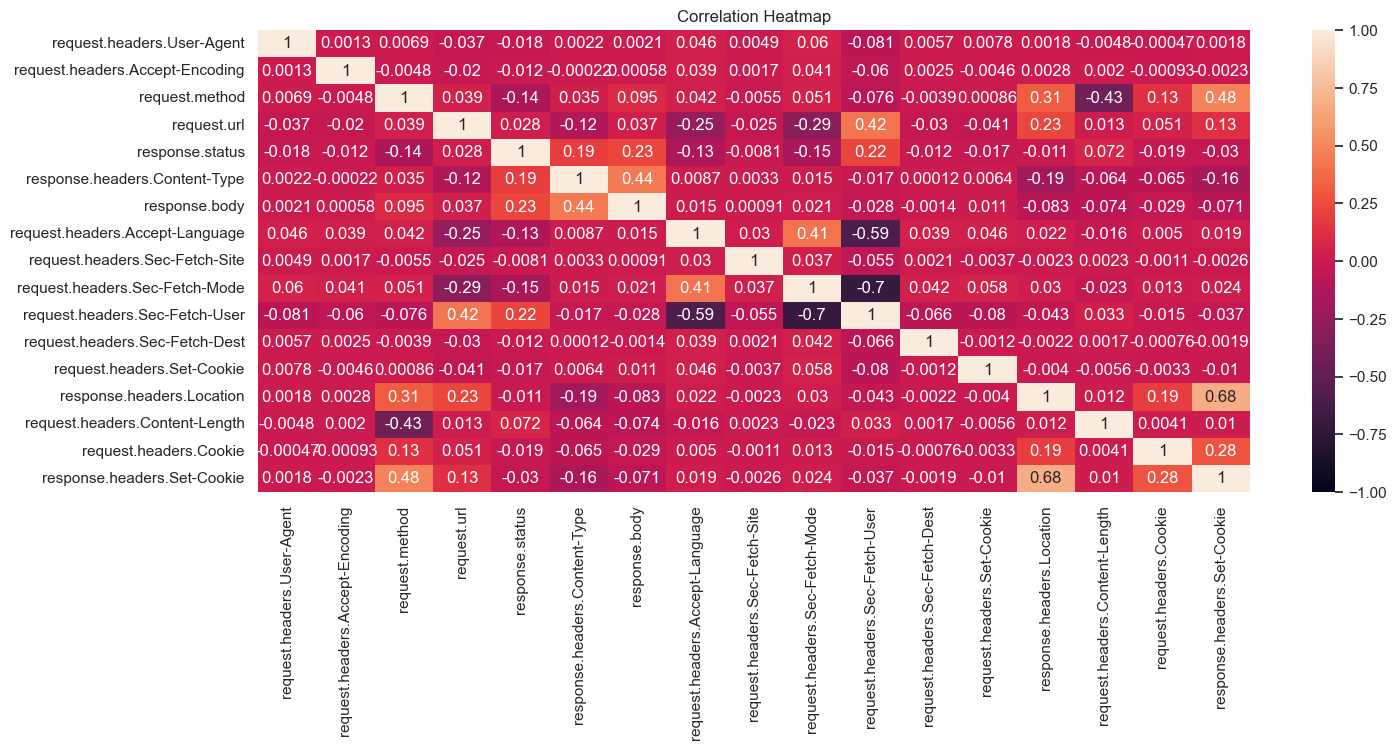

In [71]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

# Train test split

In [72]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(118995, 17) (118995,)
(25505, 17) (25505,)


Counter({'Benign': 128384,
         'XSS': 3335,
         'LOG4J': 1568,
         'Log Forging': 1627,
         'Cookie Injection': 3250,
         'SQL Injection': 3181,
         'RCE': 1593,
         'Directory Traversal': 1562})

# Model choosing and fitting

### Random Forest

In [75]:
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.datasets import make_classification
# from sklearn.utils import shuffle
# x, y1 = make_classification(n_informative= 10, n_classes=8,
#                             random_state=1)
# y2 = shuffle(y1, random_state=1)
# y3 = shuffle(y1, random_state=2)
# Y = np.vstack((y1, y2, y3)).T
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=135)
# multi_target_forest = MultiOutputClassifier(clf, n_jobs=2)
# Train Model
# multi_target_forest.fit(x, Y)
clf.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


                     precision    recall  f1-score   support

             Benign    0.95668   0.97555   0.96602     22660
   Cookie Injection    0.80488   0.80488   0.80488       574
Directory Traversal    0.90066   0.98551   0.94118       276
              LOG4J    0.87349   0.52347   0.65463       277
        Log Forging    0.40000   0.26481   0.31866       287
                RCE    0.97153   0.97153   0.97153       281
      SQL Injection    0.68889   0.49733   0.57764       561
                XSS    0.68958   0.56197   0.61927       589

           accuracy                        0.93880     25505
          macro avg    0.78571   0.69813   0.73173     25505
       weighted avg    0.93359   0.93880   0.93497     25505



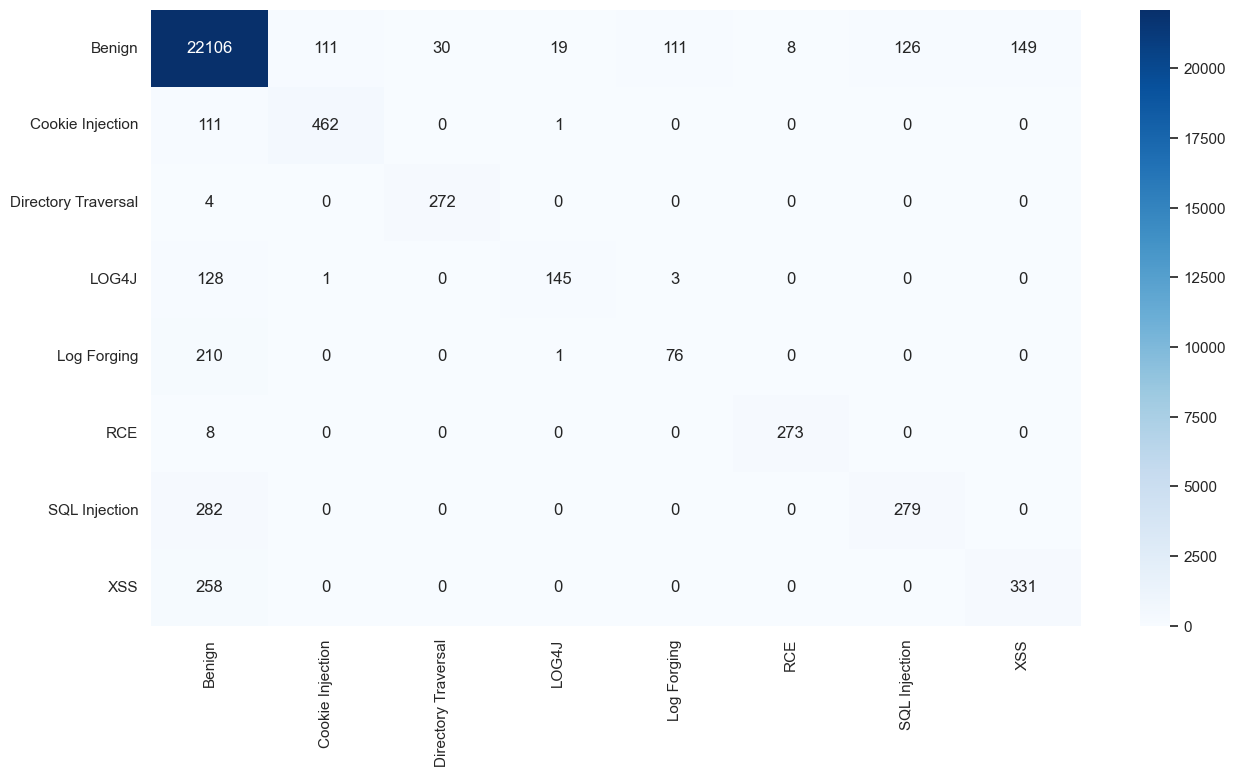

In [76]:
# We print our results
# x_test_multi= make_classification(n_informative= 10, n_classes=8,
#                             random_state=1)
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

### Naive Bayes

In [77]:
from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import make_pipeline
# nBase = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=1))
nBase = GaussianNB()
nBase.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


                     precision    recall  f1-score   support

             Benign    0.99949   0.17180   0.29320     22660
   Cookie Injection    0.72131   0.61324   0.66290       574
Directory Traversal    0.70051   1.00000   0.82388       276
              LOG4J    0.37500   0.44404   0.40661       277
        Log Forging    0.23857   1.00000   0.38523       287
                RCE    0.00000   0.00000   0.00000       281
      SQL Injection    0.04239   1.00000   0.08133       561
                XSS    0.09888   1.00000   0.17996       589

           accuracy                        0.23842     25505
          macro avg    0.39702   0.65364   0.35414     25505
       weighted avg    0.92178   0.23842   0.29903     25505



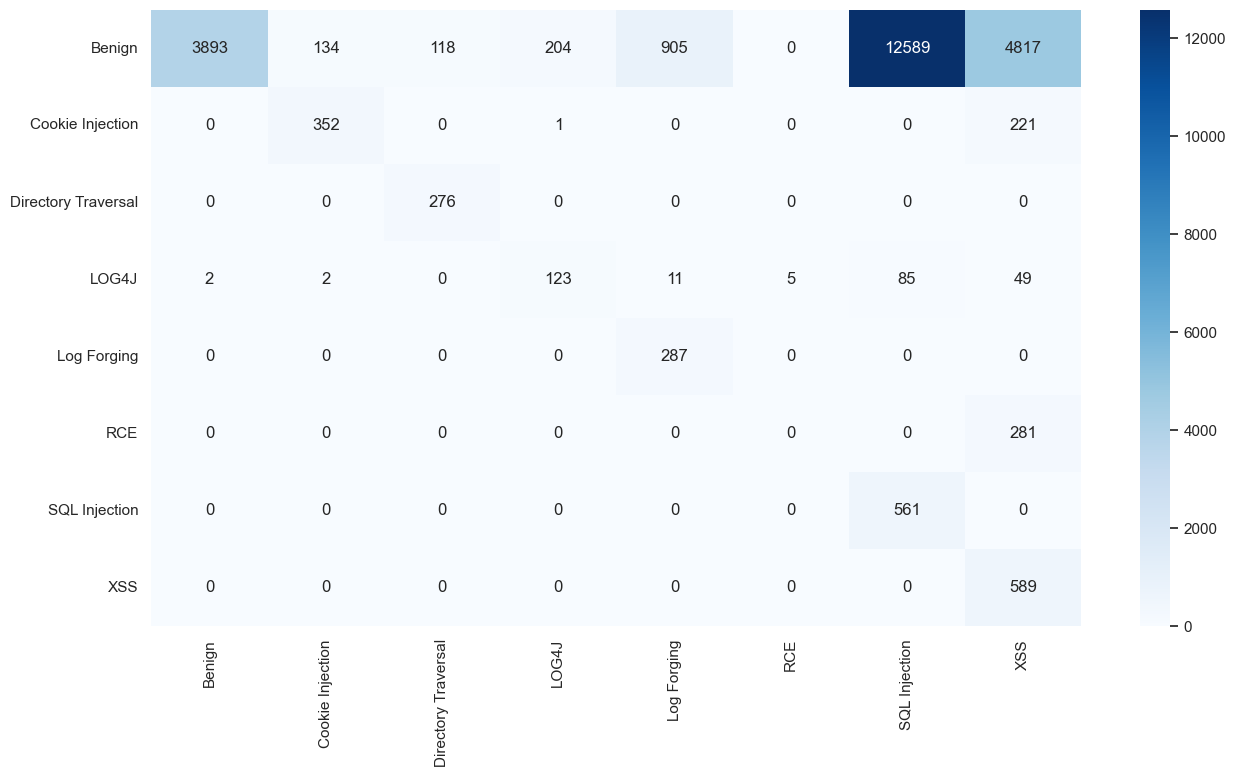

In [78]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = nBase.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Dummy 

In [98]:
from sklearn.dummy import DummyClassifier
x, y = make_classification(n_classes=3, n_clusters_per_class=1, random_state=250)

dum = DummyClassifier(strategy='stratified')
dum.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


                     precision    recall  f1-score   support

             Benign    0.88855   0.88632   0.88744     22660
   Cookie Injection    0.03004   0.02962   0.02982       574
Directory Traversal    0.01404   0.01449   0.01426       276
              LOG4J    0.00683   0.00722   0.00702       277
        Log Forging    0.01083   0.01045   0.01064       287
                RCE    0.01071   0.01068   0.01070       281
      SQL Injection    0.01411   0.01426   0.01418       561
                XSS    0.02839   0.03056   0.02944       589

           accuracy                        0.78961     25505
          macro avg    0.12544   0.12545   0.12544     25505
       weighted avg    0.79155   0.78961   0.79058     25505



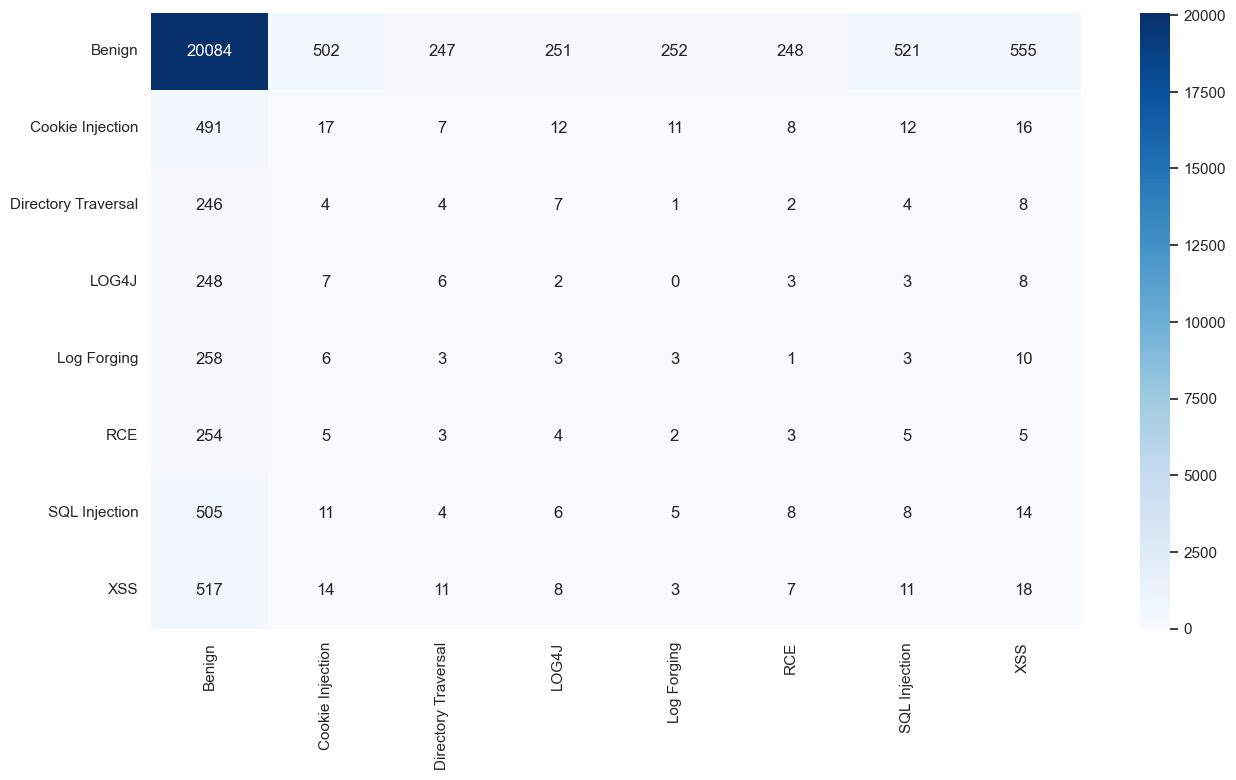

In [99]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = dum.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## KNN

In [112]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


                     precision    recall  f1-score   support

             Benign    0.93427   0.98539   0.95915     22660
   Cookie Injection    0.82927   0.71080   0.76548       574
Directory Traversal    0.71598   0.87681   0.78827       276
              LOG4J    0.99320   0.52708   0.68868       277
        Log Forging    0.40625   0.09059   0.14815       287
                RCE    0.62590   0.30961   0.41429       281
      SQL Injection    0.48077   0.08913   0.15038       561
                XSS    0.95327   0.51952   0.67253       589

           accuracy                        0.92507     25505
          macro avg    0.74236   0.51362   0.57336     25505
       weighted avg    0.91131   0.92507   0.91047     25505



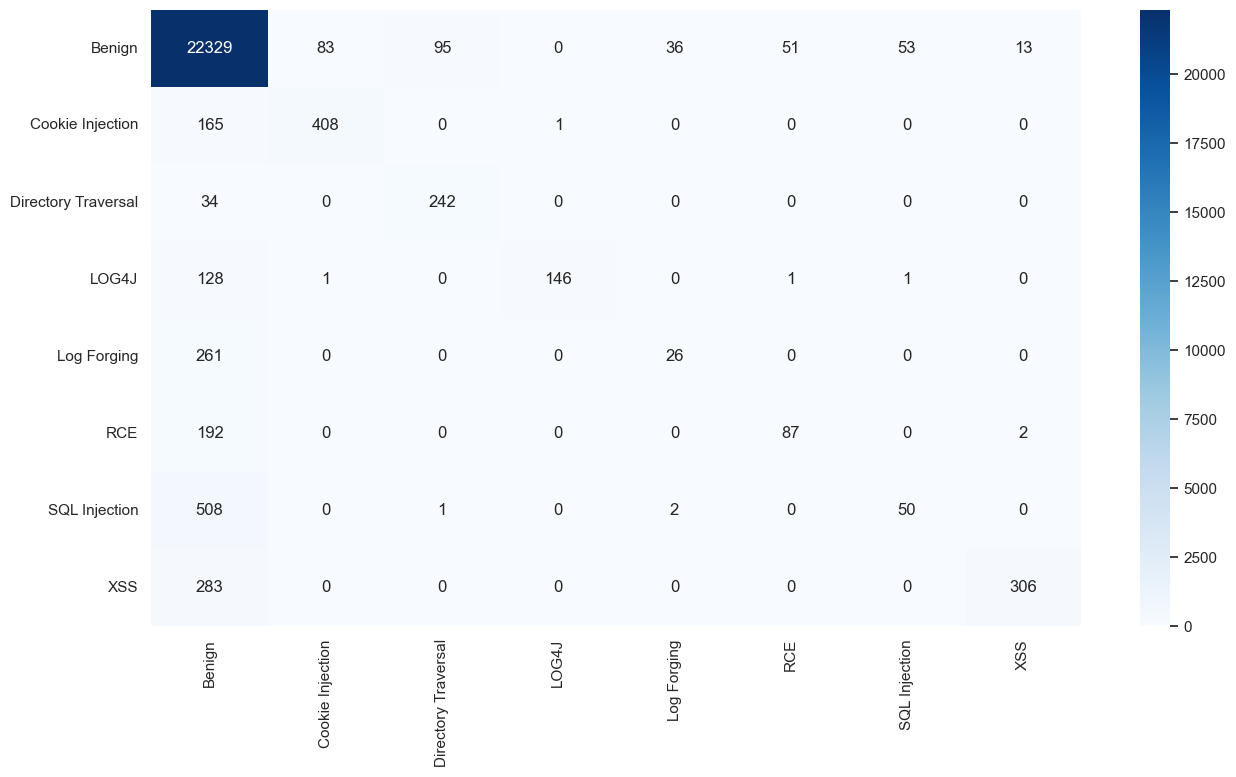

In [113]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = knn.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

##  Decision Tree

In [144]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 18).fit(X_train, y_train)
print(sorted(Counter(y_train).items()))


[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


                     precision    recall  f1-score   support

             Benign    0.95537   0.98711   0.97098     22660
   Cookie Injection    0.77315   0.87282   0.81997       574
Directory Traversal    0.90461   0.99638   0.94828       276
              LOG4J    0.72872   0.49458   0.58925       277
        Log Forging    0.48387   0.10453   0.17192       287
                RCE    0.97895   0.99288   0.98587       281
      SQL Injection    0.93571   0.46702   0.62307       561
                XSS    0.93846   0.51783   0.66740       589

           accuracy                        0.94715     25505
          macro avg    0.83735   0.67914   0.72209     25505
       weighted avg    0.94239   0.94715   0.93970     25505



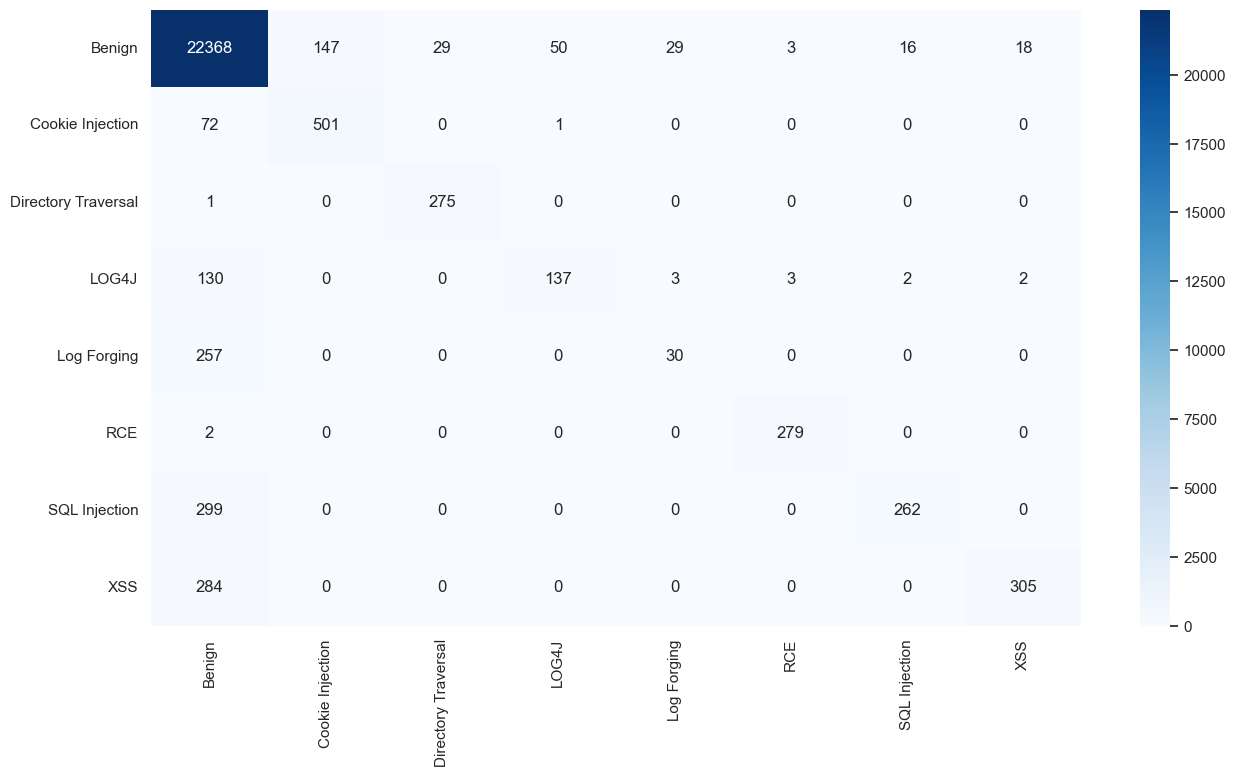

In [145]:
sns.set(rc={'figure.figsize':(15,8)})
dtree_predictions = dtree_model.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, dtree_predictions)
lc_report = classification_report(true_labels, dtree_predictions, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Ridge

In [152]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=0.5).fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

             Benign    0.90200   1.00000   0.94847     22660
   Cookie Injection    1.00000   0.50523   0.67130       574
Directory Traversal    0.00000   0.00000   0.00000       276
              LOG4J    0.98925   0.33213   0.49730       277
        Log Forging    0.00000   0.00000   0.00000       287
                RCE    0.00000   0.00000   0.00000       281
      SQL Injection    0.00000   0.00000   0.00000       561
                XSS    0.00000   0.00000   0.00000       589

           accuracy                        0.90343     25505
          macro avg    0.36141   0.22967   0.26463     25505
       weighted avg    0.83463   0.90343   0.86318     25505



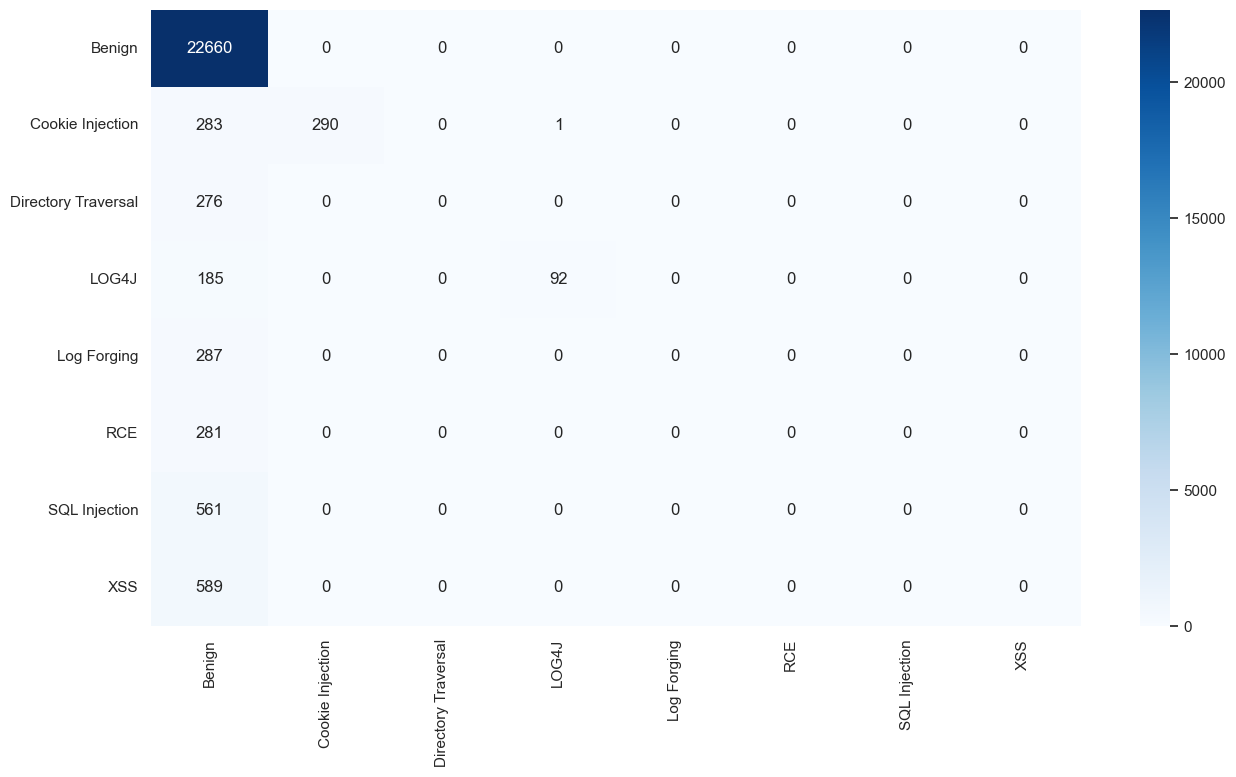

In [153]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ridge.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Ada boost

In [159]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=660)
ada.fit(X_train, y_train)

# bdt_real = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
# )

# bdt_discrete = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=2),
#     n_estimators=300,
#     learning_rate=1.5,
#     algorithm="SAMME",
# )

# bdt_real.fit(X_train, y_train)
# bdt_discrete.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

             Benign    0.89867   1.00000   0.94663     22660
   Cookie Injection    1.00000   0.50523   0.67130       574
Directory Traversal    0.00000   0.00000   0.00000       276
              LOG4J    0.00000   0.00000   0.00000       277
        Log Forging    0.00000   0.00000   0.00000       287
                RCE    0.00000   0.00000   0.00000       281
      SQL Injection    0.00000   0.00000   0.00000       561
                XSS    0.00000   0.00000   0.00000       589

           accuracy                        0.89982     25505
          macro avg    0.23733   0.18815   0.20224     25505
       weighted avg    0.82093   0.89982   0.85615     25505



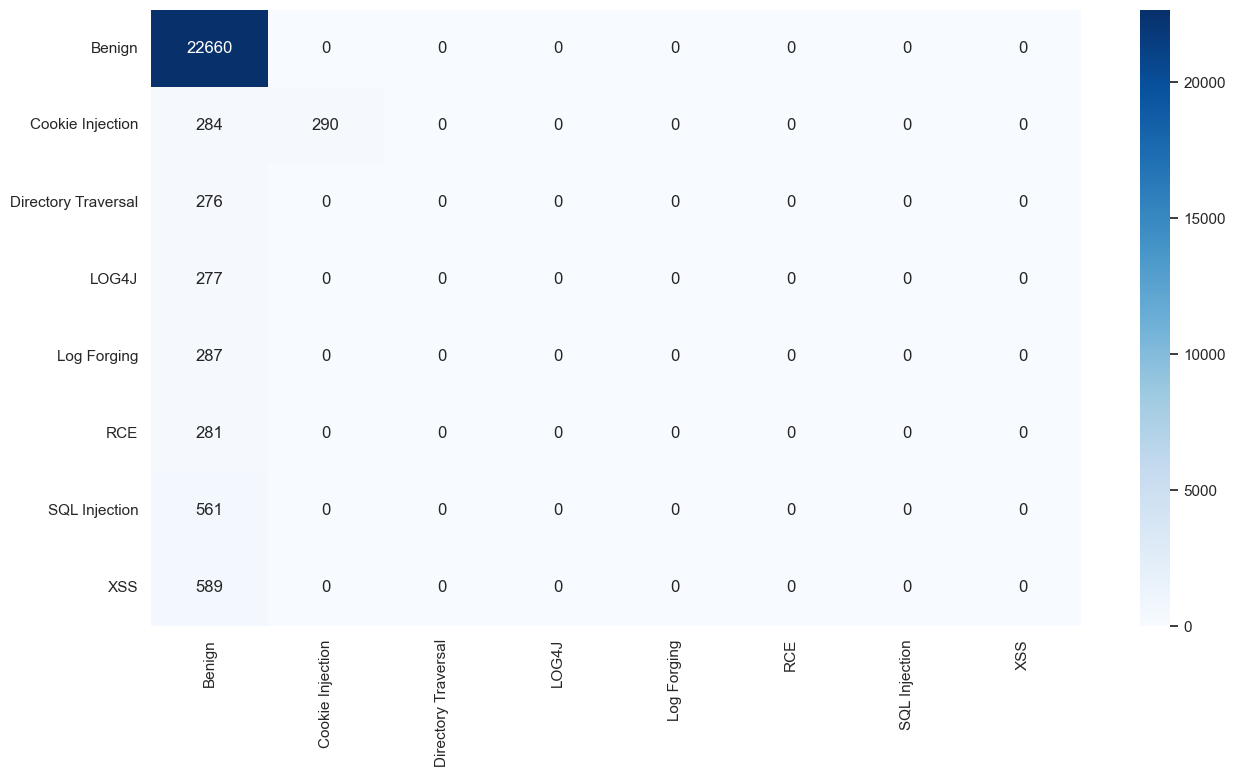

In [160]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ada.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Stacking

In [161]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('Decision Tree', dtree_model), ('Random forest', clf)],
                            n_jobs = -1) 
stack.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


C:\Users\Public\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                     precision    recall  f1-score   support

             Benign    0.95556   0.98778   0.97140     22660
   Cookie Injection    0.81802   0.79094   0.80425       574
Directory Traversal    0.90429   0.99275   0.94646       276
              LOG4J    0.97183   0.49819   0.65871       277
        Log Forging    0.48092   0.21951   0.30144       287
                RCE    0.98239   0.99288   0.98761       281
      SQL Injection    0.85802   0.49554   0.62825       561
                XSS    0.90058   0.52292   0.66165       589

           accuracy                        0.94793     25505
          macro avg    0.85895   0.68757   0.74497     25505
       weighted avg    0.94362   0.94793   0.94191     25505



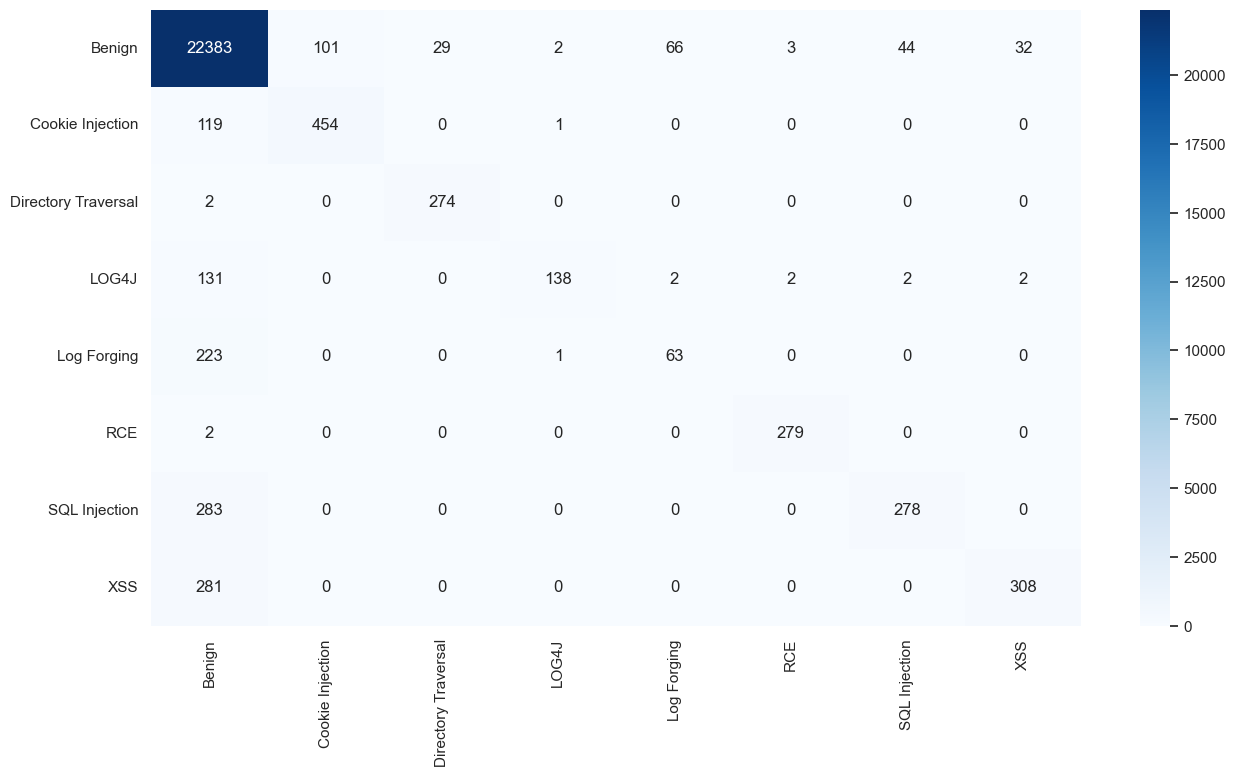

In [162]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = stack.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## hard voting

In [163]:
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('Decision Tree', dtree_model), ('Random forest', clf)], voting='hard')
vot.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


                     precision    recall  f1-score   support

             Benign    0.95058   0.99409   0.97185     22660
   Cookie Injection    0.84314   0.74913   0.79336       574
Directory Traversal    0.90572   0.97464   0.93892       276
              LOG4J    0.98639   0.52347   0.68396       277
        Log Forging    0.57143   0.05575   0.10159       287
                RCE    0.98893   0.95374   0.97101       281
      SQL Injection    0.97967   0.42959   0.59727       561
                XSS    0.98382   0.51613   0.67706       589

           accuracy                        0.94879     25505
          macro avg    0.90121   0.64957   0.71688     25505
       weighted avg    0.94563   0.94879   0.93950     25505



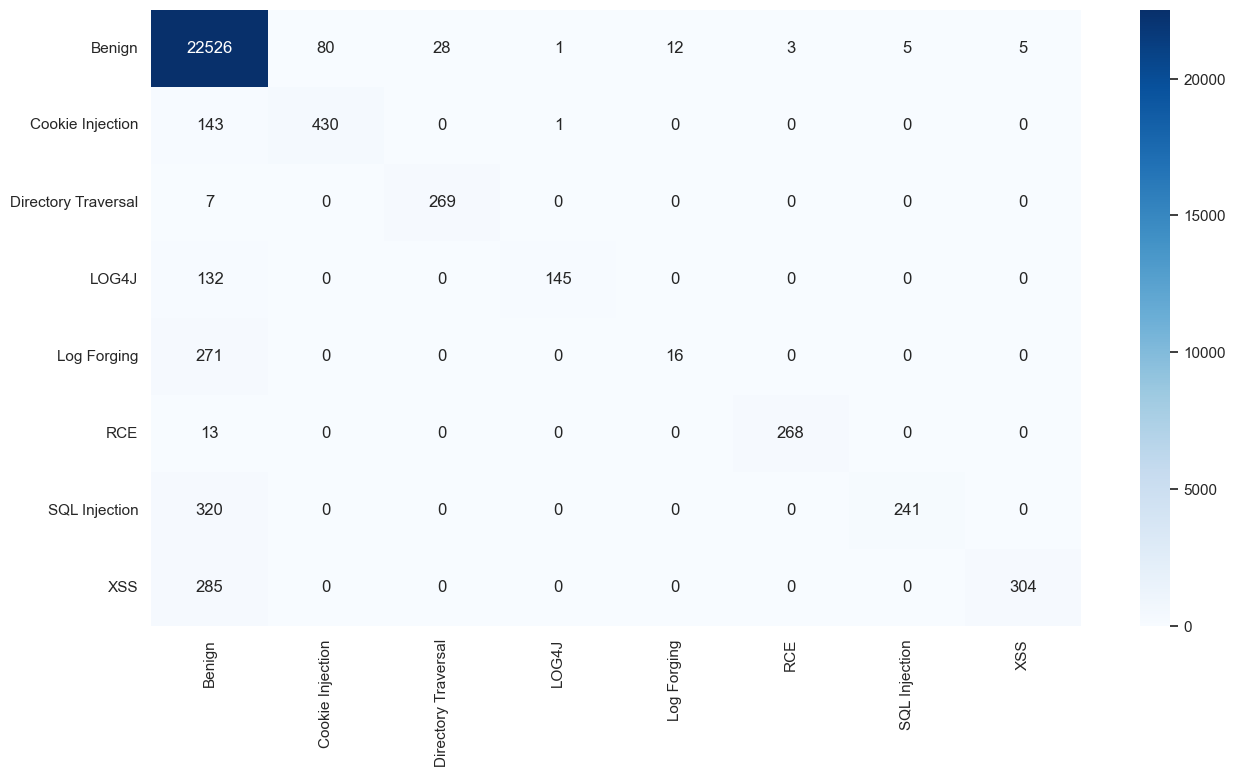

In [164]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## soft voting

In [165]:
vot_soft = VotingClassifier(estimators = [('Decision Tree', dtree_model), ('Random forest', clf)], voting='soft')
vot_soft.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105724), ('Cookie Injection', 2676), ('Directory Traversal', 1286), ('LOG4J', 1291), ('Log Forging', 1340), ('RCE', 1312), ('SQL Injection', 2620), ('XSS', 2746)]


                     precision    recall  f1-score   support

             Benign    0.95559   0.98654   0.97082     22660
   Cookie Injection    0.80656   0.81359   0.81006       574
Directory Traversal    0.90492   1.00000   0.95009       276
              LOG4J    0.77095   0.49819   0.60526       277
        Log Forging    0.48760   0.20557   0.28922       287
                RCE    0.97895   0.99288   0.98587       281
      SQL Injection    0.87987   0.48307   0.62371       561
                XSS    0.91617   0.51952   0.66306       589

           accuracy                        0.94691     25505
          macro avg    0.83758   0.68742   0.73726     25505
       weighted avg    0.94210   0.94691   0.94076     25505



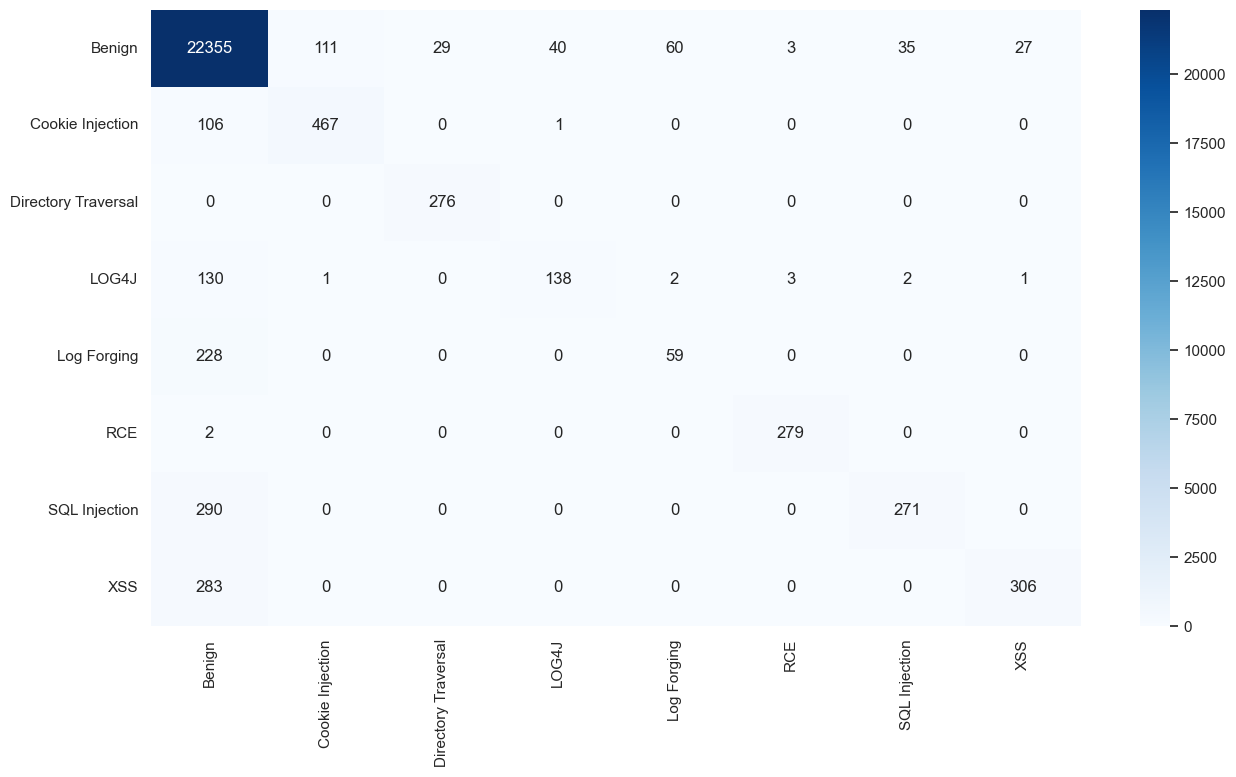

In [166]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot_soft.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)